In [1]:
#!pip install impyute
#pip install ipywidgets
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
#!pip install Pipeline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import time
import random
import numpy as np
from numpy import quantile, where
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import missingno as msno
import itertools
from pandas_profiling import ProfileReport
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.impute import SimpleImputer
from  sklearn.neighbors import LocalOutlierFactor
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from impyute.imputation.cs import fast_knn, mice
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import LimeTabular
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from imblearn.over_sampling import SMOTE, SMOTENC
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lime import lime_tabular
import shap


%matplotlib inline

import sys
sys.path.append('../..')

from utils.use_regression import (create_dummy_vars, create_formula, run_regression, calculate_vif, 
                                  calcuate_confusion_matrix, convert_results_to_df)

### 1. Import Data

In [4]:
hmda_file = '../../data/hmda_lar/cleaned_data/2_analysis_hmda_stage2.csv'


hmda_df = pd.read_csv(hmda_file) 

hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98832 entries, 0 to 98831
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   loan_amount                        98832 non-null  float64
 1   combined_loan_to_value_ratio       98832 non-null  float64
 2   loan_term                          98832 non-null  float64
 3   property_value                     98832 non-null  float64
 4   income                             98832 non-null  float64
 5   debt_to_income_ratio               98832 non-null  float64
 6   tract_population                   98832 non-null  float64
 7   tract_minority_population_percent  98832 non-null  float64
 8   ffiec_msa_md_median_family_income  98832 non-null  float64
 9   tract_to_msa_income_percentage     98832 non-null  float64
 10  tract_one_to_four_family_homes     98832 non-null  float64
 11  tract_median_age_of_housing_units  98832 non-null  flo

#####################################################3

In [5]:

Categorical = pd.DataFrame(hmda_df.apply(pd.Series.nunique))
Categorical.reset_index(inplace=True)

In [6]:
for dd in range(0,len(Categorical)):
    if Categorical.iloc[dd,1]<15 and Categorical.iloc[dd,0]!='loan_outcome': # defined that if a variable with less than 15 categories are categorical
        cat = Categorical.iloc[dd,0]
        hmda_df[cat]= hmda_df[cat].astype('category')

In [7]:
hmda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98832 entries, 0 to 98831
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   loan_amount                        98832 non-null  float64 
 1   combined_loan_to_value_ratio       98832 non-null  float64 
 2   loan_term                          98832 non-null  float64 
 3   property_value                     98832 non-null  float64 
 4   income                             98832 non-null  float64 
 5   debt_to_income_ratio               98832 non-null  float64 
 6   tract_population                   98832 non-null  float64 
 7   tract_minority_population_percent  98832 non-null  float64 
 8   ffiec_msa_md_median_family_income  98832 non-null  float64 
 9   tract_to_msa_income_percentage     98832 non-null  float64 
 10  tract_one_to_four_family_homes     98832 non-null  float64 
 11  tract_median_age_of_housing_units  98832 

In [8]:
profile = ProfileReport(hmda_df, minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

iteritems is deprecated and will be removed in a future version. Use .items instead.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:

# Note this last phase includes only the testing dataset
X_test=hmda_df.drop('loan_outcome', axis=1)
y_test=hmda_df['loan_outcome']



In [10]:
# Calculating accuracy, F1-score views
def metrics(y_pred, y_true, model_name=None):
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df2 = df.reset_index().melt('index')
  df2['index0'] = df2['variable'].astype('str') +'_'+ df2['index'].astype('str')
  df2 = df2.pivot_table(values='value', columns='index0', aggfunc='first').reset_index(drop=True)
  df2.insert(loc=0, column='model', value=model_name)
  return df2


### importing the models from file

In [11]:
import pickle

models = ['model_DT', 'model_LR', 'model_RF', 'model_EB', 'model_ML'
         ]
ID= '_1121'
for i in models:
    filename = '../../notebooks/' + i + ID + '.sav'
    exec(i + "=pickle.load(open('" + filename + "', 'rb'))")
    



### Plotting model results

In [12]:
results_df = pd.read_csv('../../notebooks/model_results.csv')
results_df.sort_values(by='f1-score_accuracy', ascending=False)


model  f1-score_0  f1-score_1  f1-score_accuracy  \
3                  EBM    0.898276    0.879065           0.889499   
2        Random Forest    0.898332    0.878035           0.889105   
1  Logistic Regression    0.893522    0.869028           0.882538   
4                  MLP    0.880625    0.871180           0.876083   
0        Decision Tree    0.820234    0.754920           0.792598   

   f1-score_macro avg  f1-score_weighted avg  precision_0  precision_1  \
3            0.888671               0.888671     0.832180     0.970726   
2            0.888184               0.888184     0.829326     0.975399   
1            0.881275               0.881275     0.817114     0.981974   
4            0.875903               0.875903     0.849484     0.907064   
0            0.787577               0.787577     0.723789     0.922506   

   precision_accuracy  precision_macro avg  ...  recall_0  recall_1  \
3            0.889499             0.901453  ...  0.975777  0.803222   
2            0.889105             0.902362  ...  0.979865  0.798345   
1            0.882538             0.899544  ...  0.985693  0.779383   
4            0.876083             0.878274  ...  0.914137  0.838028   
0            0.792598             0.823147  ...  0.946333  0.638862   

   recall_accuracy  recall_macro avg  recall_weighted avg  support_0  \
3         0.889499          0.889499             0.889499    49416.0   
2         0.889105          0.889105             0.889105    49416.0   
1         0.882538          0.882538             0.882538    49416.0   
4         0.876083          0.876083             0.876083    49416.0   
0         0.792598          0.792598             0.792598    49416.0   

   support_1  support_accuracy  support_macro avg  support_weighted avg  
3    49416.0          0.889499            98832.0               98832.0  
2    49416.0          0.889105            98832.0               98832.0  
1    49416.0          0.882538            98832.0               98832.0  
4    49416.0          0.876083            98832.0               98832.0  
0    49416.0          0.792598            98832.0               98832.0  

[5 rows x 21 columns]

### Decision Tree analysis

feature importance

In [13]:
#creating a dictionary of features and their importance values
feat_dict= {}
for col, val in sorted(zip(X_test.columns, model_DT.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [14]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})


In [15]:
feat_df.head(20)

Feature  Importance
0           gov_sponsored_loan_pchase    0.389849
1               banks_mtg_loan_pchase    0.204933
2                              income    0.077158
3                              LP_aus    0.076103
4                debt_to_income_ratio    0.059447
5                open_end_line_credit    0.034473
6   ffiec_msa_md_median_family_income    0.033371
7                    othr_loan_pchase    0.032346
8                              DU_aus    0.028849
9                         loan_amount    0.014385
10                        coapp_white    0.009147
11                     property_value    0.008146
12       combined_loan_to_value_ratio    0.004268
13  tract_minority_population_percent    0.003861
14     tract_to_msa_income_percentage    0.003368
15  tract_median_age_of_housing_units    0.002712
16                          loan_term    0.002636
17                   tract_population    0.002434
18     tract_one_to_four_family_homes    0.002157
19               vantage_credit_check    0.002079

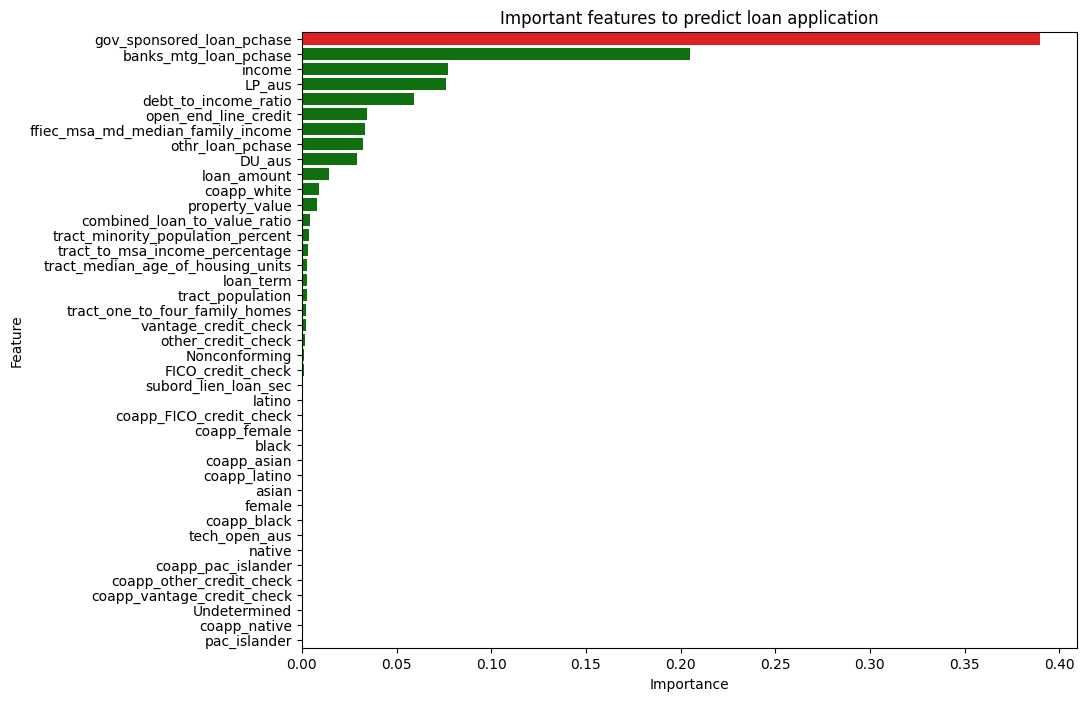

In [16]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict loan application')
plt.show()

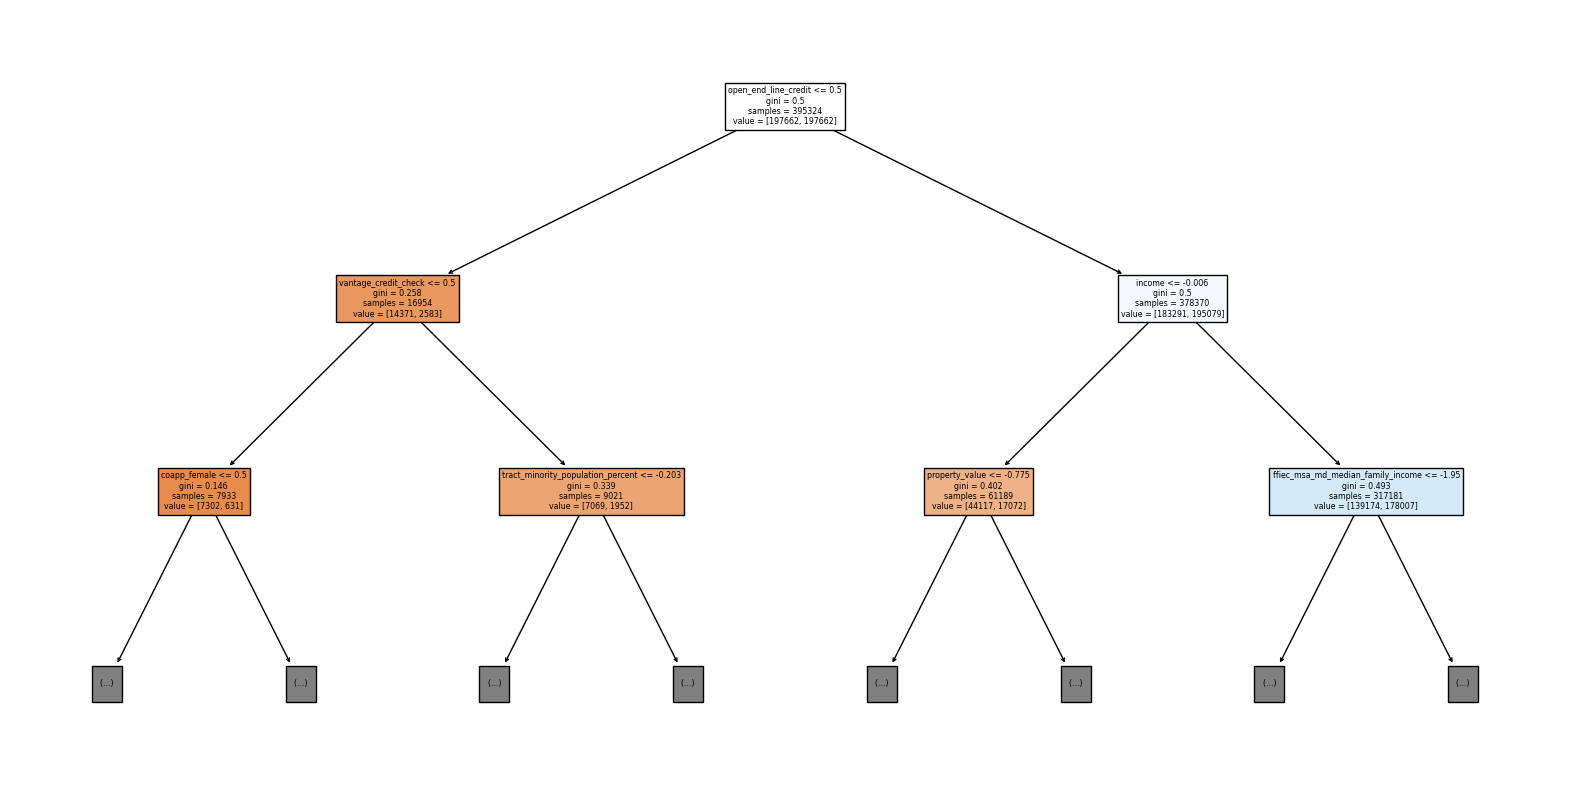

In [30]:
_, axs = plt.subplots(figsize=(20,10))
cn=['with', 'without']
tree.plot_tree(model_DT, feature_names=X_test.columns,filled=True, ax=axs, max_depth=2)
plt.show()

### Logistics Regression analysis

In [17]:
model_LR.summary()

unknown kwargs ['random_state']


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           loan_outcome   No. Observations:               395324
Model:                          Logit   Df Residuals:                   395283
Method:                           MLE   Df Model:                           40
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.6187
Time:                        20:51:20   Log-Likelihood:            -1.0447e+05
converged:                       True   LL-Null:                   -2.7402e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
loan_amount                           0.0322      0.014      2.300      0.021       0.005       0.060
combined_loan_to_value_ratio         -0.0728      0.006    -11.747      0.000      -0.085      -0.061
loan_term                            -0.0396      0.005     -7.389      0.000      -0.050      -0.029
property_value                        0.0152      0.013      1.144      0.253      -0.011       0.041
income                               -0.5825      0.293     -1.987      0.047      -1.157      -0.008
debt_to_income_ratio                 -0.6513      0.006   -111.746      0.000      -0.663      -0.640
tract_population                      0.0197      0.011      1.825      0.068      -0.001       0.041
tract_minority_population_percent    -0.0469      0.007     -6.599      0.000      -0.061      -0.033
ffiec_msa_md_median_family_income     0.2462      0.007     37.450      0.000       0.233       0.259
tract_to_msa_income_percentage        0.1117      0.006     18.482      0.000       0.100       0.124
tract_one_to_four_family_homes        0.0670      0.010      6.503      0.000       0.047       0.087
tract_median_age_of_housing_units     0.1055      0.006     17.036      0.000       0.093       0.118
Nonconforming                        -0.7037      0.022    -32.107      0.000      -0.747      -0.661
Undetermined                         23.8715      0.781     30.565      0.000      22.341      25.402
gov_sponsored_loan_pchase           -10.4455      0.277    -37.643      0.000     -10.989      -9.902
banks_mtg_loan_pchase               -10.3946      0.447    -23.237      0.000     -11.271      -9.518
othr_loan_pchase                     -8.2362      0.289    -28.491      0.000      -8.803      -7.670
coapp_white                          -0.1664      0.021     -8.088      0.000      -0.207      -0.126
coapp_black                           0.1044      0.049      2.135      0.033       0.009       0.200
coapp_latino                          0.1062      0.033      3.219      0.001       0.042       0.171
coapp_asian                           0.1200      0.033      3.661      0.000       0.056       0.184
coapp_native                          0.2784      0.133      2.100      0.036       0.019       0.538
coapp_pac_islander                    0.6185      0.230      2.685      0.007       0.167       1.070
coapp_female                         -0.2113      0.021    -10.080      0.000      -0.252      -0.170
subord_lien_loan_sec                 -0.1630      0.034     -4.817      0.000      -0.229      -0.097
open_end_line_credit                  0.5878      0.036     16.458      0.000       0.518       0.658
FICO_credit_check                    -0.3723      0.020    -18.290      0.000      -0.412      -0.332
vantage_credit_check                  0.1330      0.046      2.881      0.004       0.043       0.224
other_credit_check                   -0.4078      0.039    -10.476      0.000  

In [18]:
model_odds = pd.DataFrame(np.exp(model_LR.params), columns=['odds_ratio'])
model_odds.reset_index(names='features', inplace=True)

features = ['black', 'native', 'latino', 'asian', 'pac_islander']

model_odds[model_odds['features'].isin(features)].sort_values(by='odds_ratio', ascending=False)


features  odds_ratio
38        native    1.843340
39  pac_islander    1.836214
35         black    1.655370
36        latino    1.376250
37         asian    1.125397

In [55]:
features = ['FICO_credit_check', 'vantage_credit_check',
            'other_credit_check']

model_odds[model_odds['features'].isin(features)].sort_values(by='odds_ratio', ascending=False)

features  odds_ratio
27  vantage_credit_check    1.142268
26     FICO_credit_check    0.689118
28    other_credit_check    0.665145

### EBM Model Interpretation

In [19]:

ebm_global = model_EB.explain_global()
show(ebm_global)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


<!-- http://127.0.0.1:7001/2622575284800/ -->

In [20]:
y_test_denied = y_test[y_test==0]
X_test_denied = X_test.loc[X_test.index.isin(y_test_denied.index)]
print(X_test_denied.shape, y_test_denied.shape)

(49416, 41) (49416,)


In [21]:
X_test_denied.reset_index(drop=True, inplace=True)
y_test_denied.reset_index(drop=True, inplace=True)

getting the rows where we can check specific races

In [22]:
print('Latino sample: ' + str(X_test_denied.index[X_test_denied['latino'] == 0][0]))
print('Black sample: ' + str(X_test_denied.index[X_test_denied['black'] == 0][0]))
print('Native sample: ' + str(X_test_denied.index[X_test_denied['native'] == 0][0]))
print('Pacific Islander sample: ' + str(X_test_denied.index[X_test_denied['pac_islander'] == 0][0]))


Latino sample: 3
Black sample: 8
Native sample: 13
Pacific Islander sample: 207


In [25]:
X_sample = X_test_denied.iloc[[3, 8, 13, 207],]
y_sample = y_test_denied.iloc[[3, 8, 13, 207],]


In [26]:
ebm_local = model_EB.explain_local(X_sample, y_sample) #X_test_std,y_test_bal
show(ebm_local)

<!-- http://127.0.0.1:7001/2622896336144/ -->

### Interpreting the Multilayer Perceptron with LIME

In [37]:
from lime import lime_tabular

Investigating in Lime the same EBM samples that indicate
- Sample 4: Loan denied to a Latino
- Sample 7: Loan denied to an Asian
- Sample 8: Loan denied to a Pacific Islander
- Sample 9: Loan denied to a Black


In [27]:
# %% Apply lime
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=model_ML.predict_proba, 
                   data=X_test, 
                   #feature_names= X.columns,
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_sample,
                                y_sample,
                                name='LIME')

show(lime_local)

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPCl

<!-- http://127.0.0.1:7001/2622896335856/ -->

In [28]:
explainer = lime_tabular.LimeTabularExplainer(X_test.to_numpy(), mode="classification", feature_names= X_test.columns)
explainer

In [29]:
predictions = model_ML.predict(X_sample)


In [30]:
pred_denied=np.where(predictions==0)

In [31]:
pred_denied


(array([0, 1, 2, 3], dtype=int64),)

In [32]:
X_test_std_np = X_sample.to_numpy()


In [33]:
for x in range(4):
  explanation = explainer.explain_instance(X_test_std_np[pred_denied[0][x]], model_ML.predict_proba, num_features=len(X_test.columns))
  explanation.show_in_notebook()
  explanation.save_to_file('LIME_'+str(x)+'.html')


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



### Interpreting Random Forest with SHAP

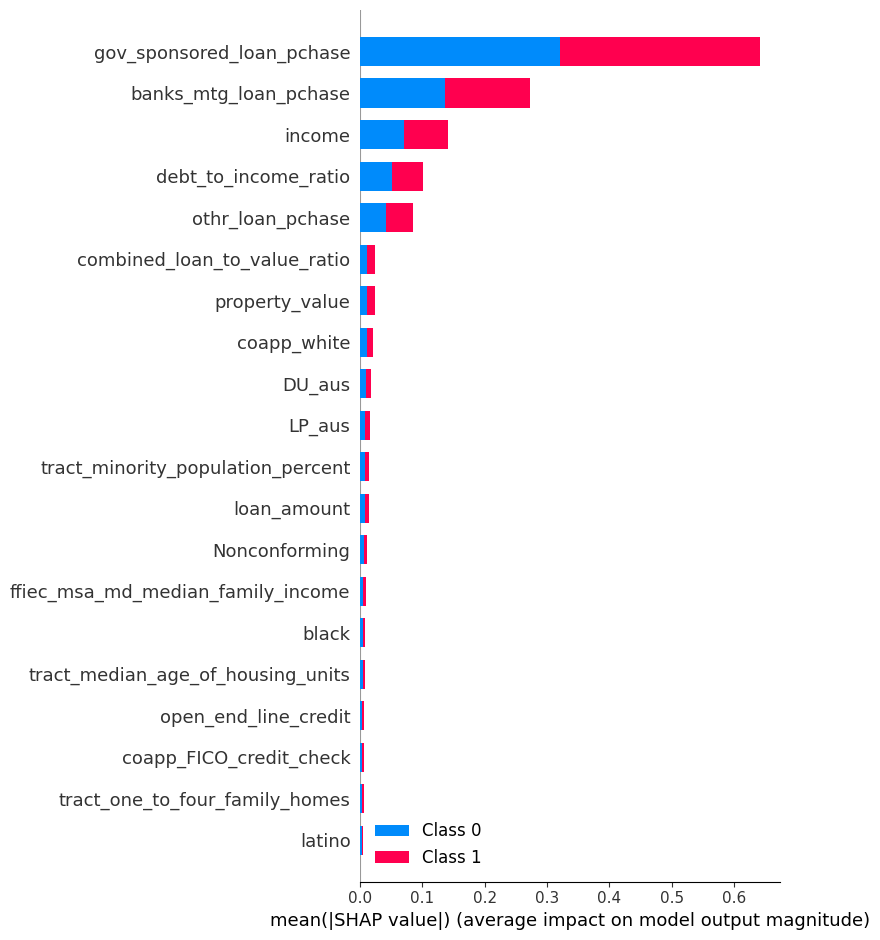

In [51]:
import shap 
shap_values = shap.TreeExplainer(model_RF).shap_values(X_test[:100])

shap.summary_plot(shap_values, X_test[:100], plot_type="bar")




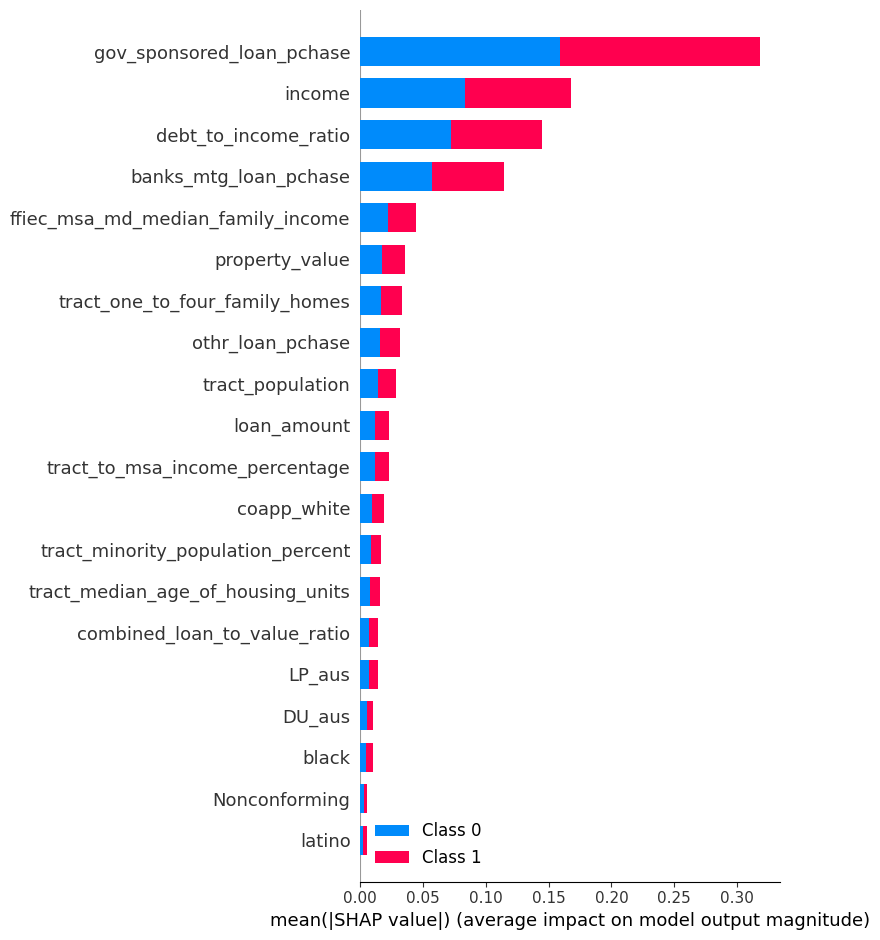

In [34]:
shap_values = shap.TreeExplainer(model_RF).shap_values(X_sample)


shap.summary_plot(shap_values, X_sample, plot_type="bar")


In [69]:
""" y_test_denied = y_test_bal[y_test_bal == 0]
X_test_denied = X_test_std.loc[X_test_std.index.isin(y_test_denied.index)]
print(X_test_denied.shape, y_test_denied.shape) """


(49416, 41) (49416,)


In [35]:
explainer = shap.TreeExplainer(model_RF)

In [36]:
model_RF.predict(X_sample).mean()


0.0

In [37]:
shap_values = explainer.shap_values(X_sample)


In [38]:
explainer.expected_value


array([0.49996072, 0.50003928])

Sample 4

In [49]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][0],
                X_sample.iloc[0,])  # for values



Sample: Latino Individual

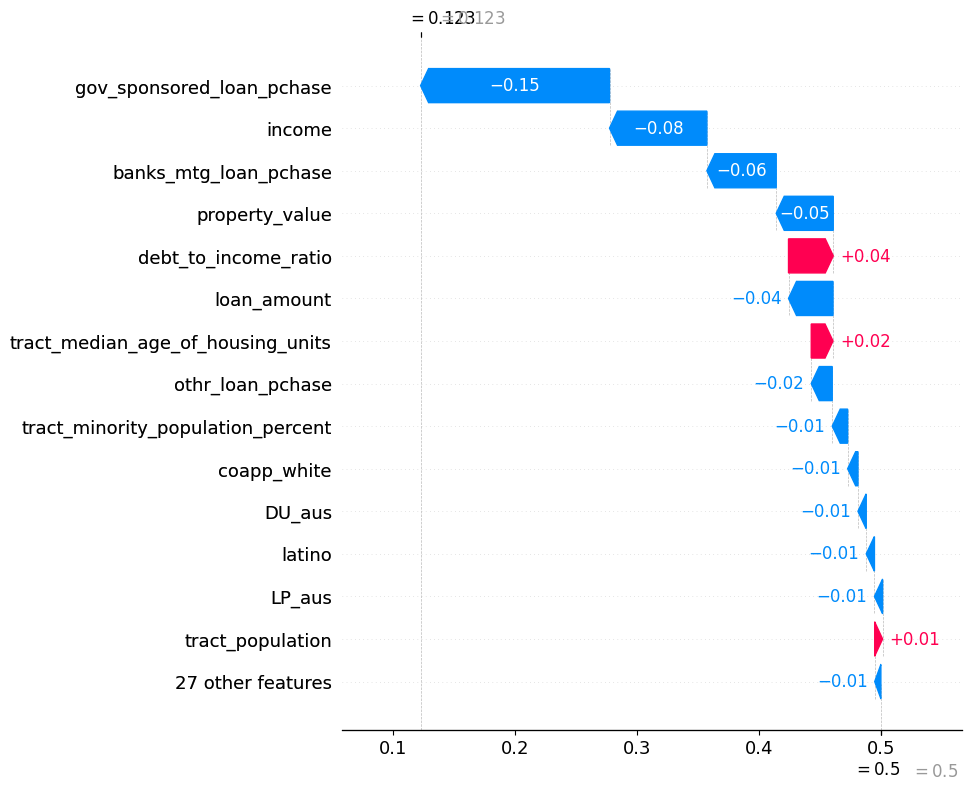

In [52]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][0], feature_names=X_test.columns, max_display=15)


Sample: Black individual

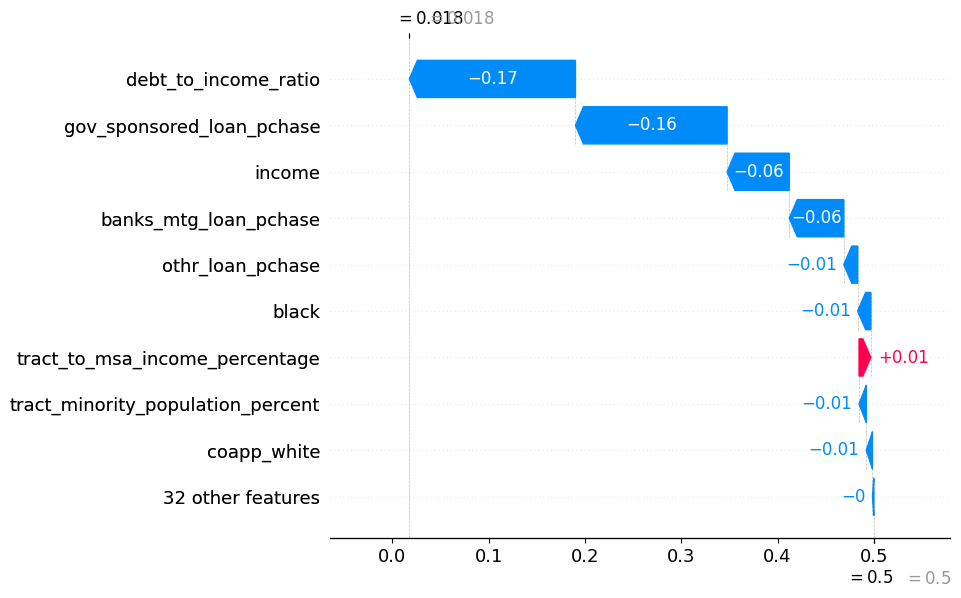

In [51]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][1], feature_names=X_test.columns, max_display=10)


Sample 13: Native Individual

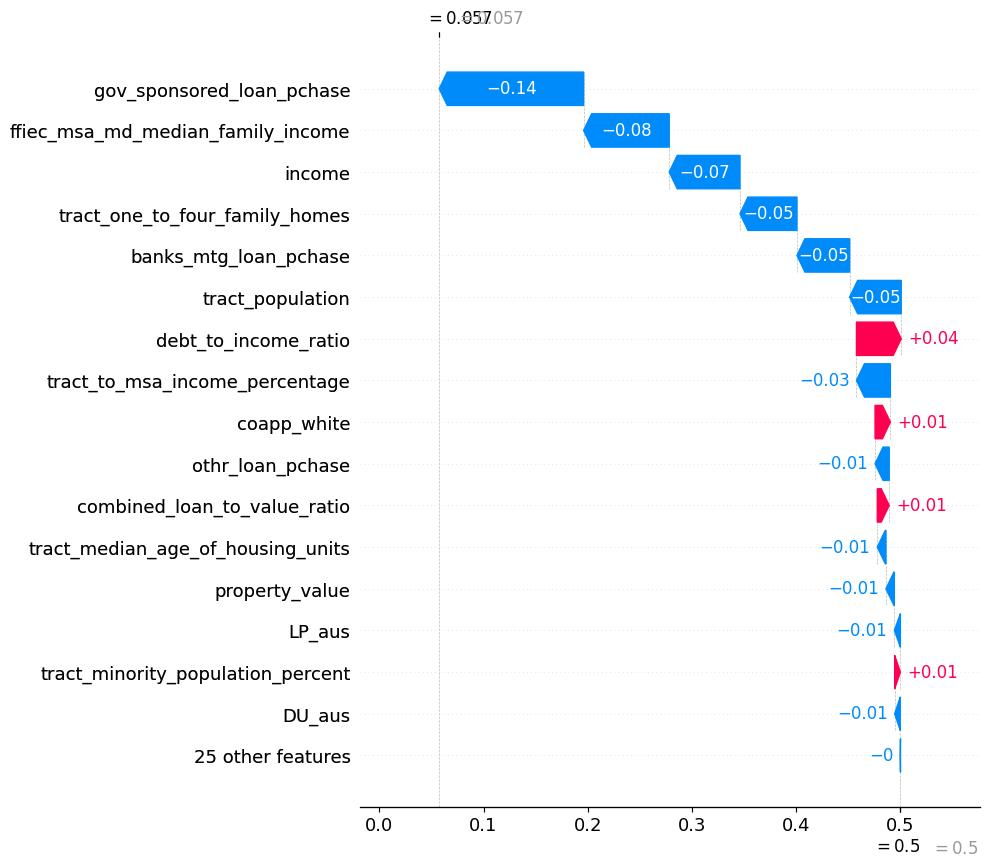

In [53]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][2], feature_names=X_test.columns, max_display=17)


Sample: Pacific Islander

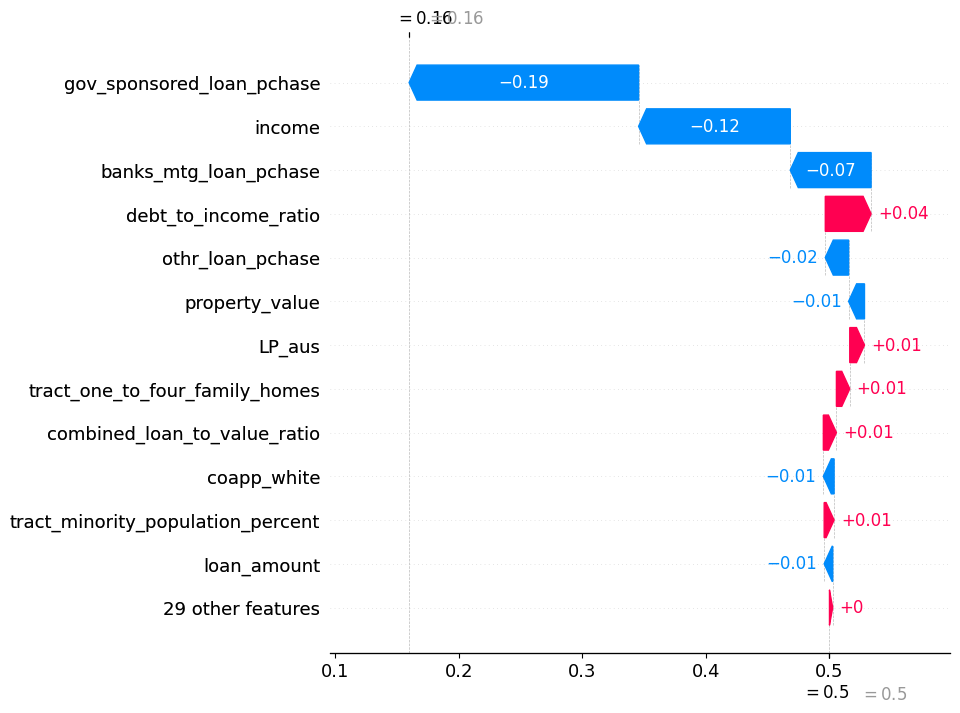

In [54]:

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                       shap_values[1][3], feature_names=X_test.columns, max_display=13)


In [55]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][2],
                X_test_denied.iloc[[8],])  # for values


In [56]:
shap.initjs()
# Force plot

shap.force_plot(explainer.expected_value[1],
                shap_values[1][3],
                X_test_denied.iloc[[9],])  # for values


In [139]:
shap_values = explainer.shap_values(X_test_denied.iloc[[1,3, 8, 13],])


In [143]:
shap_values[1][3]


array([ 2.54979707e-03,  8.62095935e-03,  9.27701942e-04, -6.73635974e-03,
       -6.88188747e-02,  4.56797073e-02, -7.52031835e-02,  3.47394637e-03,
       -6.95660100e-02, -3.20305200e-02, -6.50631515e-02, -1.83728920e-02,
       -3.05483880e-03, -2.09813928e-05, -1.24600981e-01, -4.79743052e-02,
       -1.30215921e-02,  1.44915040e-02,  2.14235496e-05, -2.51762554e-04,
        1.35251573e-05, -9.35763750e-06, -9.58595907e-07, -1.91385657e-03,
       -6.56615221e-05,  1.41201503e-03,  5.33354089e-04,  4.33409308e-05,
       -2.04299928e-04, -1.90973548e-03, -2.82566980e-06, -3.15667713e-06,
       -5.61720696e-03, -5.77345693e-03,  9.96695008e-06,  1.89206983e-03,
        9.41633869e-04,  1.96756223e-04, -9.41764282e-04, -5.13283953e-06,
        1.43546783e-04])

In [ ]:
shap_values = explainer.shap_values(X_test_denied.iloc[[1],])


In [82]:
shap_value_plot = explainer.shap_values(X_test_denied.iloc[[1, 3, 8, 13],])


In [86]:
explainerer = shap.TreeExplainer(model_RF, X_test_denied.iloc[[1, 3, 8, 13],])


In [87]:
shap_values = explainerer(X_test_denied.iloc[[1, 3, 8, 13],])


: 

: 

In [84]:

shap_values = explainerer(X)
feature_names = [
    a + ": " + str(b) for a, b in zip(X.columns, np.abs(shap_values.values).mean(0).round(2))
]

shap.summary_plot(shap_values, X, max_display=X.shape[1],
                  feature_names=feature_names)


In [85]:
# %% >> Visualize global features
# Feature summary
feature_names = [
    a + ": " + str(b) for a, b in zip(X_test_denied.columns, np.abs(shap_value_plot.values).mean(0).round(2))
]
shap.summary_plot(shap_value_plot, X_test_denied.iloc[[1, 3, 8, 13],],
                  max_display=X_test_denied.shape[1],
                  feature_names=feature_names)


AttributeError: 'list' object has no attribute 'values'

In [ ]:
shap.dependence_plot(column(black?), shap_values, X)